### Import packages and get routes for analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

import pymysql

from math import sqrt
from time import time

#Code so that numpy floats can be recognised in mySQL
pymysql.converters.encoders[np.float64] = pymysql.converters.escape_float
pymysql.converters.conversions = pymysql.converters.encoders.copy()
pymysql.converters.conversions.update(pymysql.converters.decoders)

localhost = "localhost"
user = 'MY_USER'
passwd = 'MY_PASS'
db = 'dublin_bus_time'
port = 3306

conn = pymysql.connect(host=localhost, user=user,
        passwd=passwd, db=db,
        port=port)
cursor = conn.cursor()

cursor.execute("""select r.route, b.direction
from dublin_bus_time.model_route r, (SELECT distinct route, direction 
                                    FROM dublin_bus_time.bus_stops_correct
                                    where direction is not null
                                    order by 1, 2) as b
where r.route = b.route""")

routes = cursor.fetchall()

routes = [list(i) for i in routes]

conn.close()



### Linear Regression and Random Forest

In [ ]:
#Connect to the database
conn = pymysql.connect(host=localhost, user=user,
        passwd=passwd, db=db,
        port=port)
cursor = conn.cursor()

for route in routes:
    
    sql = """SELECT b.date, b.weekday, b.StopPointID, (b.ActualTime_Arr - b.PlannedTime_Arr) as ActualTime_Arr, b.temp, b.wind_speed, b.morning_rush, b.evening_rush ,b.bank_holiday 
                FROM dublin_bus_time.route_""" + route[0] + """ b, (select distinct route, direction, stopid 
                                                    from dublin_bus_time.bus_stops_correct
                                                    where route = '""" + route[0] + """'
                                                    and direction = '""" + str(route[1]) + """') c
                where b.LineID = c.route
                and b.Direction = c.direction
                and b.StopPointID = c.stopid
                and b.ProgrNumber <> 1"""
    
    df = pd.read_sql_query(sql, conn, parse_dates=['date'])
    
    #drop any rows with null values
    df = df.dropna()
    df = pd.get_dummies(df)
    
    #split the data into train and test
    train = df[df['date'] < '2018-10-01']
    test = df[df['date'] >= '2018-10-01']
    
    train = train.drop(['date'], 1)
    test = test.drop(['date'], 1)
    
    #Need to reset indexes for test
    test.reset_index(drop=True, inplace=True)
    
    X_train = train.drop(['ActualTime_Arr'], 1)
    Y_train = train['ActualTime_Arr']
    X_test = test.drop(['ActualTime_Arr'], 1)
    Y_test = test['ActualTime_Arr']
    
    #Linear Regression
    start_time = time()
    multiple_linreg = LinearRegression().fit(X_train, Y_train)
    end_time = time()
    lr_elapsed_time = end_time - start_time
    
    # calculate the prediction
    multiple_linreg_predictions_test = multiple_linreg.predict(X_test)
    
    #Get the model metrics
    lr_mae = metrics.mean_absolute_error(Y_test, multiple_linreg_predictions_test)
    lr_rmse = sqrt(metrics.mean_squared_error(Y_test, multiple_linreg_predictions_test))
    
    #Random Forest
    rfr = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
    start_time = time()
    rfr = rfr.fit(X_train, Y_train)
    end_time = time()
    rf_elapsed_time = end_time - start_time
    
    rfr_predictions_test = rfr.predict(X_test)
    
    #Get the model metrics
    rf_mae = metrics.mean_absolute_error(Y_test, rfr_predictions_test)
    rf_rmse = sqrt(metrics.mean_squared_error(Y_test, rfr_predictions_test))

    
    cursor.execute("""insert into dublin_bus_time.model_results (routeid, direction, linreg_mae, linreg_rmse, linreg_time, rf_mae, rf_rmse, rf_time)
                        values (%s, %s, %s, %s, %s, %s, %s, %s)""", (route[0], str(route[1]), str(lr_mae), str(lr_rmse), str(lr_elapsed_time), str(rf_mae), str(rf_rmse), str(rf_elapsed_time)))
    
    conn.commit()
    
    
conn.close()


### Neural Network Model

In [ ]:
#Connect to database
conn = pymysql.connect(host=localhost, user=user,
        passwd=passwd, db=db,
        port=port)
cursor = conn.cursor()

for route in routes:
    
    sql = """SELECT b.date, b.weekday, b.StopPointID, (b.ActualTime_Arr - b.PlannedTime_Arr) as ActualTime_Arr, b.temp, b.wind_speed, b.morning_rush, b.evening_rush ,b.bank_holiday 
                    FROM dublin_bus_time.route_""" + route[0] + """ b, (select distinct route, direction, stopid 
                                                        from dublin_bus_time.bus_stops_correct
                                                        where route = '""" + route[0] + """'
                                                        and direction = '""" + str(route[1]) + """') c
                    where b.LineID = c.route
                    and b.Direction = c.direction
                    and b.StopPointID = c.stopid
                    and b.ProgrNumber <> 1"""

    df = pd.read_sql_query(sql, conn, parse_dates=['date'])

    #drop any rows with null values
    df = df.dropna()
    df = pd.get_dummies(df)

    #split the data into train and test
    train = df[df['date'] < '2018-10-01']
    test = df[df['date'] >= '2018-10-01']

    train = train.drop(['date'], 1)
    test = test.drop(['date'], 1)

    #Need to reset indexes for test
    test.reset_index(drop=True, inplace=True)

    X_train = train.drop(['ActualTime_Arr'], 1)
    Y_train = train['ActualTime_Arr']
    X_test = test.drop(['ActualTime_Arr'], 1)
    Y_test = test['ActualTime_Arr']

    #Neural Network
    start_time = time()
    MLP = MLPRegressor().fit(X_train, Y_train)
    end_time = time()
    MLP_elapsed_time = end_time - start_time

    # calculate the prediction
    MLP_predictions_test = MLP.predict(X_test)

    #Get the model metrics
    MLP_mae = metrics.mean_absolute_error(Y_test, MLP_predictions_test)
    MLP_rmse = sqrt(metrics.mean_squared_error(Y_test, MLP_predictions_test))

    #update model_results table in database
    cursor.execute("""update dublin_bus_time.model_results
                            set nn_mae = %s, nn_rmse = %s, nn_time = %s
                            where routeid = %s
                            and direction = %s""", (MLP_mae, MLP_rmse, MLP_elapsed_time, route[0], str(route[1])))
    conn.commit()
    
    
conn.close()


### LGBM

In [ ]:
#Connect to database
conn = pymysql.connect(host=localhost, user=user,
        passwd=passwd, db=db,
        port=port)
cursor = conn.cursor()

for route in routes:
    
    sql = """SELECT b.date, b.direction, cast(b.hour as unsigned) as hour, b.StopPointID, b.ProgrNumber, b.temp, cast(b.weekday as unsigned) as weekday, (b.ActualTime_Arr - b.PlannedTime_Arr) as journey_time, b.bank_holiday 
                    FROM dublin_bus_time.route_""" + route[0] + """ b, (select distinct route, direction, stopid 
                                                        from dublin_bus_time.bus_stops_correct
                                                        where route = '""" + route[0] + """'
                                                        and direction = '""" + str(route[1]) + """') c
                    where b.LineID = c.route
                    and b.Direction = c.direction
                    and b.StopPointID = c.stopid
                    and b.ProgrNumber <> 1"""

    df = pd.read_sql_query(sql, conn, parse_dates=['date'])

    #drop any rows with null values
    df = df.dropna()
    df = pd.get_dummies(df)
    
    #remove outliers
    #df = df[np.abs(df["journey_time"]-df["journey_time"].mean())<=(1.5*df["journey_time"].std())]
    
    #Transform time columns
    def time_transform(df, col, max_val):
        df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
        df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
        df = df.drop([col], axis = 1)
        return df
    
    df = time_transform(df, 'weekday', 7)
    df = time_transform(df, 'hour', 24)

    #split the data into train and test
    train = df[df['date'] < '2018-10-01']
    test = df[df['date'] >= '2018-10-01']

    train = train.drop(['date'], 1)
    test = test.drop(['date'], 1)

    #Need to reset indexes for test
    test.reset_index(drop=True, inplace=True)

    X_train = train.drop(['journey_time'], 1)
    Y_train = train['journey_time']
    X_test = test.drop(['journey_time'], 1)
    Y_test = test['journey_time']

    #Neural Network
    start_time = time()
    lgb_turned = lgb.LGBMRegressor()
    lgb_turned.fit(X_train, Y_train)
    end_time = time()
    lgb_elapsed_time = end_time - start_time

    # calculate the prediction
    lgb_predictions_test = lgb_turned.predict(X_test)

    #Get the model metrics
    lgb_mae = metrics.mean_absolute_error(Y_test, lgb_predictions_test)
    lgb_rmse = sqrt(metrics.mean_squared_error(Y_test, lgb_predictions_test))

    #update model_results table in database
    cursor.execute("""update dublin_bus_time.model_results
                            set lgbm_mae = %s, lgbm_rmse = %s, lgbm_time = %s
                            where routeid = %s
                            and direction = %s""", (lgb_mae, lgb_rmse, lgb_elapsed_time, route[0], str(route[1])))
    conn.commit()
    
    
conn.close()


### Results

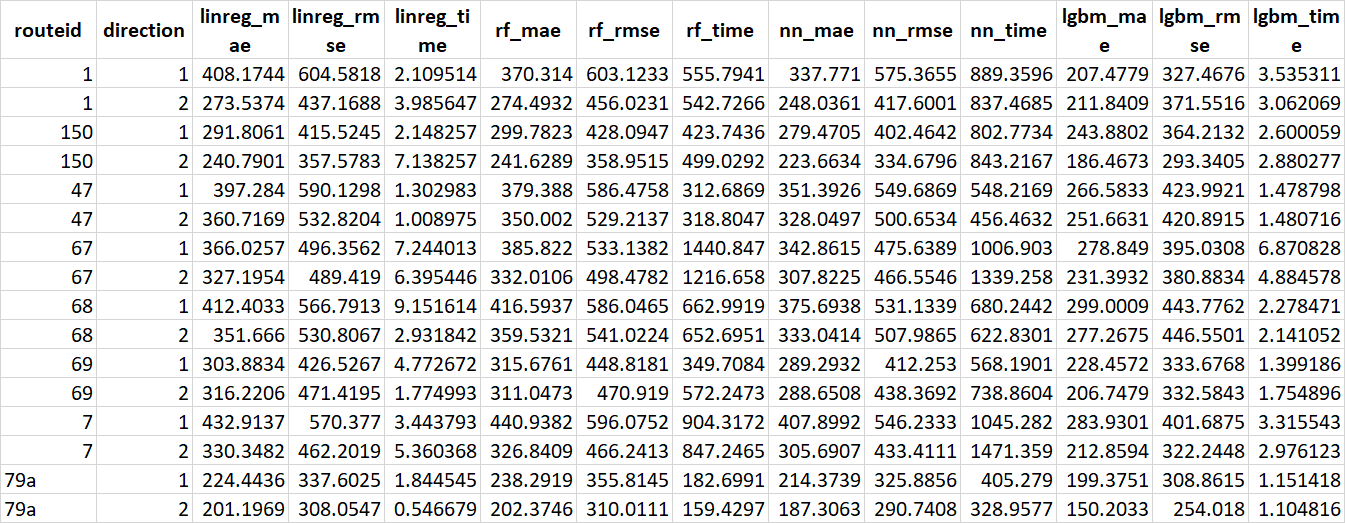

### Averages Summary

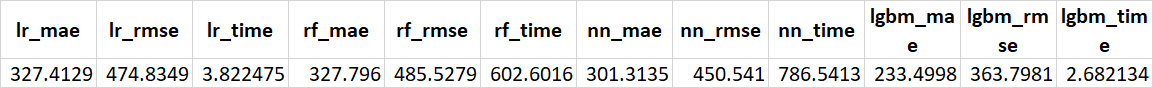